In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import models
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.init as init
import torch.nn.functional as F



from PIL import Image
import random
import math
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict

from sklearn.model_selection import train_test_split


from torchmetrics.functional import structural_similarity_index_measure
from torch.nn.utils import spectral_norm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
from tbos_models import *

In [4]:
IMG_SIZE= 256
BATCH_SIZE=4

ROOT = "/kaggle/input/tbos-dataset"
BBOX_PATH = "/kaggle/input/tbos-dataset/bb_images.txt"

GEN_WTS = ""
DISC_WTS = ""

LR = 1e-5
BETA1 = 0.5
BETA2 = 0.999

NUM_EPOCHS = 5

In [5]:
class BirdsDataset(Dataset):

    def __init__(self, root, split = "train", transformation = None, captions_per_img = 10, bbox_path= None, WORDS_NUM= 20):
        super().__init__()

        self.root= root
        self.split = split
        self.split_dir = os.path.join(root, split)
        self.WORDS_NUM= WORDS_NUM
        self.transform = transformation
        
        self.embeddings_num = captions_per_img

        self.train_filenames= self.get_filenames(self, os.path.join(root, "train"))
        self.test_filenames = self.get_filenames(self, os.path.join(root, "test"))

        self.bboxes = {}
        if bbox_path is not None:
            with open(bbox_path, "r") as file:
                for line in file:
                    parts = line.strip().split()
                    sno = parts[0]
                    fname = parts[1].split("/")[-1]  # Extract filename only
                    coords = list(map(float, parts[2:]))  # Convert x1, x2, y1, y2 to floats
                    self.bboxes[fname] = coords

        self.captions, self.ixtoword, self.wordtoix, self.n_words = self.get_text_data(root, split)

        self.class_to_id = {folder: idx for idx, folder in enumerate(sorted(os.listdir(self.split_dir)))}


    def get_filenames(self, root, split_dir):

        file_names=[]

        for class_folder in sorted(os.listdir(split_dir)):

            for img_name in sorted(os.listdir(os.path.join(split_dir, class_folder))):

                if not img_name.endswith('_rgb.jpg'):
                    file_names.append(os.path.join(class_folder, img_name))

        return file_names
    
    def load_captions(self, root, file_names):
        
        text_dir = os.path.join(root, "text_c10")
        all_captions=[]

        for filename in file_names:
            caps_path = os.path.join(text_dir, filename[:-3]+"txt")

            with open(caps_path, "r") as f:
                captions = f.read().encode('utf-8').decode('utf8').split('\n')

                cnt = 0
                for cap in captions:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace("\ufffd\ufffd", " ")
                    # picks out sequences of alphanumeric characters as tokens
                    # and drops everything else
                    tokenizer = RegexpTokenizer(r'\w+')
                    tokens = tokenizer.tokenize(cap.lower())
                    # print('tokens', tokens)
                    if len(tokens) == 0:
                        print('cap', cap)
                        continue

                    tokens_new = []
                    for t in tokens:
                        t = t.encode('ascii', 'ignore').decode('ascii')
                        if len(t) > 0:
                            tokens_new.append(t)
                    all_captions.append(tokens_new)

                    cnt += 1
                    if cnt == self.embeddings_num:
                        break
                if cnt < self.embeddings_num:
                    print('ERROR: the captions for %s less than %d'
                          % (filename, cnt))
                    
        return all_captions

    def build_dict(self, train_captions, test_captions):

        word_counts = defaultdict(float)

        captions_list = train_captions + test_captions

        for caption in captions_list:
            for word in caption:
                word_counts[word]+=1

        vocab = [w for w in word_counts if word_counts[w] >= 0]

        ### 1 based indexing over vocab-list, 0th index is taken by EOS
        ixtoword = {}
        ixtoword[0] = '<end>'

        wordtoix = {}
        wordtoix['<end>'] = 0

        ix = 1

        for w in vocab:
            wordtoix[w] = ix
            ixtoword[ix] = w
            ix += 1
 
        ###converting ["A", "B", ..] to [1,2,....] using wordtoix, encoding the tokens into numerals
        train_captions_new = []
        for t in train_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            train_captions_new.append(rev)

        test_captions_new = []
        for t in test_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            test_captions_new.append(rev)


        ### IN THE ORIGINAL CODE THEY ALSO RETURN TEST_CAPTIONS_TOGETHER
        ### I THINK IT MAKES SENSE, BECAUSE ONLY THEN WOULD THE TRAIN AND TEST VOCABS MATCH
        return [train_captions_new, test_captions_new, ixtoword, wordtoix, len(ixtoword)]

    def get_text_data(self, root, split):

        train_captions = self.load_captions(root, self.train_filenames)
        test_captions = self.load_captions(root, self.test_filenames)

        [train_captions, test_captions, ixtoword, wordtoix, n_words] = self.build_dict(train_captions, test_captions)

        if( split == "train"):
            return  train_captions, ixtoword, wordtoix, n_words
        else:
            return  test_captions, ixtoword, wordtoix, n_words

    def get_img(self, img_path, transform=None, bbox=None):

        img = Image.open(img_path).convert("RGB")
        width, height = img.size

        if bbox is not None:
            r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - r)
            y2 = np.minimum(height, center_y + r)
            x1 = np.maximum(0, center_x - r)
            x2 = np.minimum(width, center_x + r)
            img = img.crop([x1, y1, x2, y2])

        if transform is not None:
            img = transform(img)
        return img  ### IN THE ORIGINAL CODE THEY RETURN AS A LIST BECAUSE THEY'RE USING BRANCHES (BASICALLY DIFFERENT SIZES OF THE SAME IMG) 
    
    def get_caption(self, sent_idx):

        # get caption corresponding to sent_idx
        sent_caption = np.asarray(self.captions[sent_idx]).astype('int64')

        ## If the caption already contains an EOS (0) token
        if (sent_caption == 0).sum() > 0:
            print('ERROR: do not need END (0) token', sent_caption)

        num_words = len(sent_caption)
        # pad with 0s (i.e., '<end>') 
        x = np.zeros((self.WORDS_NUM, 1), dtype='int64')
        x_len = num_words
        if num_words <= self.WORDS_NUM:
            x[:num_words, 0] = sent_caption
        else:
            ix = list(np.arange(num_words))  # 1, 2, 3,..., maxNum
            np.random.shuffle(ix)
            ix = ix[:self.WORDS_NUM]
            ix = np.sort(ix)
            x[:, 0] = sent_caption[ix]
            x_len = self.WORDS_NUM

        # Convert indices back to words
        caption_words = [self.ixtoword[idx] for idx in sent_caption if idx in self.ixtoword]
        caption_text = " ".join(caption_words)        
        
        return x, x_len, caption_text

    def __len__(self):
        if(self.split == "train"):
            return len(self.train_filenames)
        
        return len(self.test_filenames)

    def __getitem__(self, index):
        
        if self.split=="train":
            filename= self.train_filenames[index]
            filepath = os.path.join(self.split_dir,filename)
        else:
            filename = self.test_filenames[index]
            filepath = os.path.join(self.split_dir,filename)

        bbox= self.bboxes[filename.split("/")[-1]]

        image = self.get_img(filepath, self.transform,bbox)

        sentence_idx= random.randint(0, self.embeddings_num-1)
        new_idx = index * self.embeddings_num + sentence_idx

        captions, len_caps, caption_text = self.get_caption(new_idx)

        class_folder = filename.split(os.sep)[0]  # Extract the class folder name
        # print(class_folder, filename )
        class_id = self.class_to_id[class_folder]  # Map class folder to class ID

        return image, captions, len_caps, class_id, caption_text   


In [6]:
def sort_by_caption_lengths(imgs, captions, caption_lengths, cls_ids, caption_texts):
    """
    Sorts the inputs from the dataset in decreasing order of caption lengths.
    
    Args:
        imgs (torch.Tensor): Tensor of images (B, C, H, W).
        captions (torch.Tensor): Tensor of captions (B, max_caption_length).
        caption_lengths (torch.Tensor): Tensor of caption lengths (B).
        cls_ids (torch.Tensor): Tensor of class IDs (B).
        caption_texts (list of str): List of caption strings.
    
    Returns:
        tuple: Sorted (imgs, captions, caption_lengths, cls_ids, caption_texts).
    """
    # Sort the caption lengths in decreasing order
    caption_lengths, sorted_indices = torch.sort(caption_lengths, descending=True)
    
    # Rearrange the inputs to match the sorted indices
    imgs = imgs[sorted_indices]
    captions = captions[sorted_indices]
    cls_ids = cls_ids[sorted_indices]
    caption_texts = [caption_texts[i] for i in sorted_indices.cpu().numpy()]  # For list
    
    return imgs, captions, caption_lengths, cls_ids, caption_texts



def get_data(dataloader):
    
    imgs, captions, cap_lens, class_ids, cap_text = next(iter(dataloader))
    
    sorted_imgs, sorted_captions, sorted_caption_lengths, sorted_cls_ids, sorted_caption_texts = \
        sort_by_caption_lengths(imgs, captions, cap_lens, class_ids, cap_text)

    # print(sorted_caption_lengths)
    if(torch.cuda.is_available()):
        sorted_imgs = sorted_imgs.cuda()
        sorted_captions = sorted_captions.cuda()
        sorted_caption_lengths = sorted_caption_lengths.cuda()
        sorted_cls_ids = sorted_cls_ids.cuda()
        # sorted_caption_texts = sorted_caption_texts.cuda()

    return [sorted_imgs, sorted_captions, sorted_caption_lengths, sorted_cls_ids, sorted_caption_texts]

def get_mask():
        
    mask = []
    IMAGE_SIZE = IMG_SIZE
    
    for i in range(BATCH_SIZE):
        
        q1 = p1 = IMG_SIZE // 4
        q2 = p2 = IMG_SIZE - IMG_SIZE // 4
            
        m = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        m[q1:q2 + 1, p1:p2 + 1] = 1
        m = np.expand_dims(m, 0)
        mask.append(m)
            
    mask = np.array(mask)
    mask = torch.from_numpy(mask)

    if torch.cuda.is_available():
        mask = mask.float().cuda()
    return mask

In [7]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [8]:
dataset = BirdsDataset(root = ROOT, split= "train", bbox_path = BBOX_PATH, transformation = train_tf)
dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)

## PreTrained

In [9]:
image_encoder = CNN_ENCODER(IMG_SIZE)

img_encoder_path = "/kaggle/input/damsm_pretrained/pytorch/default/1/bird/image_encoder200.pth"
state_dict = torch.load(img_encoder_path, map_location=lambda storage, loc: storage)
image_encoder.load_state_dict(state_dict)
for p in image_encoder.parameters():
    p.requires_grad = False
print('Load image encoder from:', img_encoder_path)
image_encoder.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:01<00:00, 84.5MB/s] 
<ipython-input-9-8b6ced34ed97>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be fl

Load pretrained model from  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Load image encoder from: /kaggle/input/damsm_pretrained/pytorch/default/1/bird/image_encoder200.pth


CNN_ENCODER(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, 

In [10]:
text_encoder = RNN_ENCODER(dataset.n_words, nhidden=IMG_SIZE)

text_encoder_path = "/kaggle/input/damsm_pretrained/pytorch/default/1/bird/text_encoder200.pth"
state_dict = torch.load(text_encoder_path, map_location=lambda storage, loc: storage)
text_encoder.load_state_dict(state_dict)
for p in text_encoder.parameters():
    p.requires_grad = False
print('Load text encoder from:', text_encoder_path)
text_encoder.eval()

Load text encoder from: /kaggle/input/damsm_pretrained/pytorch/default/1/bird/text_encoder200.pth


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
<ipython-input-10-a7b35b7d11c1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=

RNN_ENCODER(
  (encoder): Embedding(5450, 300)
  (drop): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(300, 128, batch_first=True, dropout=0.5, bidirectional=True)
)

## Inpaint Net

### CoarseNet

In [11]:
class CoarseNet(nn.Module):

    def __init__(self, c_img=3,
                 norm='instance', act_en='leaky_relu', act_de='relu'):#instance normalisation is being there!

        super().__init__()
        #initially number of channels is 64 
        cnum = 64
        #Layer 1 
        self.en_1 = nn.Conv2d(c_img, cnum, 4,2,padding = 1)
        self.en_2 = CoarseEncodeBlock(cnum, cnum*2, 4, 2, normalization = norm, activation = act_en)
        self.en_3 = CoarseEncodeBlock(cnum*2, cnum*4, 4, 2, normalization=norm, activation=act_en)
        self.en_4 = CoarseEncodeBlock(cnum*4, cnum*8, 4, 2, normalization=norm, activation=act_en)
        self.en_5 = CoarseEncodeBlock(cnum*16, cnum*8, 4, 2, normalization=norm, activation=act_en)
        self.en_6 = CoarseEncodeBlock(cnum*8, cnum*8, 4, 2, normalization=norm, activation=act_en)
        self.en_7 = CoarseEncodeBlock(cnum*8, cnum*8, 4, 2, normalization=norm, activation=act_en)
        self.en_8 = CoarseEncodeBlock(cnum*8, cnum*8, 4, 2, activation=act_en)


        # Defining the decoder layers
        self.de_8 = CoarseDecodeBlock(cnum*8, cnum*8, 3, 2, normalization=norm, activation=act_de)
        self.de_7 = CoarseDecodeBlock(cnum*8*2, cnum*8, 3, 2, normalization=norm, activation=act_de)
        self.de_6 = CoarseDecodeBlock(cnum*8*2, cnum*8, 3, 2, normalization=norm, activation=act_de)
        self.de_5 = CoarseDecodeBlock(cnum*8*2, cnum*8, 3, 2, normalization=norm, activation=act_de)
        self.de_4 = CoarseDecodeBlock(cnum*8*2, cnum*4, 3, 2, normalization=norm, activation=act_de)
        self.de_3 = CoarseDecodeBlock(cnum*4*2, cnum*2, 3, 2, normalization=norm, activation=act_de)
        self.de_2 = CoarseDecodeBlock(cnum*2*2, cnum, 3, 2, normalization=norm, activation=act_de)
        self.de_1 = nn.Sequential(
            get_act(act_de),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(cnum*2, c_img, 3, padding=1),
            get_act('tanh')
        )


        self.ca_net = CA_NET()
        self.h_net1 = INIT_STAGE_G(512, 100)
        self.h_net2 = NEXT_STAGE_G(32, 256, 100)
        self.h_net3 = NEXT_STAGE_G(32, 256, 100)
        self.attn = SelfAttention(512)
        
        self.text_en_1 = nn.Conv2d(32, cnum, 4, 2, padding=1)
        self.text_en_2 = CoarseEncodeBlock(cnum, cnum*2, 4, 2, normalization=norm, activation=act_en)
        self.text_en_3 = CoarseEncodeBlock(cnum*2, cnum*4, 4, 2, normalization=norm, activation=act_en)
        self.text_en_4 = CoarseEncodeBlock(cnum*4, cnum*8, 4, 2, normalization=norm, activation=act_en)


    # def forward(self, x, z_code, sent_emb, word_embs, text_mask):

    def forward(self, x, z_code, sent_emb, word_embs, text_mask):
        
        ################## Image Encoder 1 ###################
        out_1 = self.en_1(x)
        out_2 = self.en_2(out_1)
        out_3 = self.en_3(out_2)
        out_4 = self.en_4(out_3)
        # print("out 4", out_4.shape)
        
        #################### Attention ######################
        attn_feature = self.attn(out_4, word_embs)

        # print("IMAGE ADAPTIVE", attn_feature.shape)
                
        ################## Text 2 Image ######################

        
        att_maps = []
        c_code, mu, logvar = self.ca_net(sent_emb) 
        # print("CA NET", c_code.shape)

        h_code1 = self.h_net1(z_code, c_code)
        # print("HNET1", h_code1.shape)

        h_code2, att1 = self.h_net2(h_code1, c_code, word_embs, text_mask) 
        # print("HNET2", h_code2.shape, att1.shape)
        if att1 is not None:
            att_maps.append(att1)   
        h_code3, att2 = self.h_net3(h_code2, c_code, attn_feature, text_mask)
        # print("HNET 3", h_code3.shape, att2.shape)
        if att2 is not None:
            att_maps.append(att2)
            
        # ################## Text-Image Encoder #################

        
        text_out_1 = self.text_en_1(h_code3)
        text_out_2 = self.text_en_2(text_out_1)
        text_out_3 = self.text_en_3(text_out_2)
        text_out_4 = self.text_en_4(text_out_3)


        # ###RANDOM CHECKING
        # req_shape = out_4.shape
        # text_out_4 = torch.randn(req_shape).to(device)
        # att1 = torch.randn((4, 15, 64, 64)).to(device)
        # att2 = torch.randn((4,15,128,128)).to(device)
        # print(text_out_4.shape)
        ################## Image Encoder 2 ###################
        
        out_4_t = torch.cat([out_4 , text_out_4], 1)

        # print("concatenated", out_4_t.shape)

        out_5 = self.en_5(out_4_t)
        out_6 = self.en_6(out_5)
        out_7 = self.en_7(out_6)
        out_8 = self.en_8(out_7)
        
        ##################### Decoder #########################
        # print(out_8.shape)
        dout_8 = self.de_8(out_8)
        dout_8_out_7 = torch.cat([dout_8, out_7], 1)
        dout_7 = self.de_7(dout_8_out_7)
        dout_7_out_6 = torch.cat([dout_7, out_6], 1)
        dout_6 = self.de_6(dout_7_out_6)
        dout_6_out_5 = torch.cat([dout_6, out_5], 1)
        dout_5 = self.de_5(dout_6_out_5)
        dout_5_out_4 = torch.cat([dout_5, out_4], 1)
        dout_4 = self.de_4(dout_5_out_4)
        dout_4_out_3 = torch.cat([dout_4, out_3], 1)
        dout_3 = self.de_3(dout_4_out_3)
        dout_3_out_2 = torch.cat([dout_3, out_2], 1)
        dout_2 = self.de_2(dout_3_out_2)
        dout_2_out_1 = torch.cat([dout_2, out_1], 1)
        dout_1 = self.de_1(dout_2_out_1)
       
        # return dout_1, att1, att2

        return dout_1, att1, att2


### RefineNet

In [12]:
class RefineNet(nn.Module):
    def __init__(self, c_img=3,
                 norm='instance', act_en='leaky_relu', act_de='relu'):
        super().__init__()

        c_in = c_img + c_img
        cnum = 64

        self.en_1 = nn.Conv2d(c_in, cnum, 3, 1, padding=1)
        self.en_2 = RefineEncodeBlock(cnum, cnum*2, normalization=norm, activation=act_en)
        self.en_3 = RefineEncodeBlock(cnum*2, cnum*4, normalization=norm, activation=act_en)
        self.en_4 = RefineEncodeBlock(cnum*4, cnum*8, normalization=norm, activation=act_en)
        self.en_5 = RefineEncodeBlock(cnum*8, cnum*8, normalization=norm, activation=act_en)
        self.en_6 = RefineEncodeBlock(cnum*8, cnum*8, normalization=norm, activation=act_en)
        self.en_7 = RefineEncodeBlock(cnum*8, cnum*8, normalization=norm, activation=act_en)
        self.en_8 = RefineEncodeBlock(cnum*8, cnum*8, normalization=norm, activation=act_en)
        self.en_9 = nn.Sequential(
            get_act(act_en),
            nn.Conv2d(cnum*8, cnum*8, 4, 2, padding=1))

        self.de_9 = nn.Sequential(
                get_act(act_de),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(cnum*8, cnum*8, 3, padding=1),
                get_norm(norm, cnum*8))
        self.de_8 = RefineDecodeBlock(cnum*8*2, cnum*8, normalization=norm, activation=act_de)
        self.de_7 = RefineDecodeBlock(cnum*8*2, cnum*8, normalization=norm, activation=act_de)
        self.de_6 = RefineDecodeBlock(cnum*8*2, cnum*8, normalization=norm, activation=act_de)
        self.de_5 = RefineDecodeBlock(cnum*8*2, cnum*8, normalization=norm, activation=act_de)
        self.de_4 = RefineDecodeBlock(cnum*8*2, cnum*4, normalization=norm, activation=act_de)
        self.de_3 = RefineDecodeBlock(cnum*4*2, cnum*2, normalization=norm, activation=act_de)
        self.de_2 = RefineDecodeBlock(cnum*2*2, cnum, normalization=norm, activation=act_de)
        self.de_1 = nn.Sequential(
                    get_act(act_de),
                    # nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                    nn.Conv2d(cnum*2, c_img, 3, padding=1),
                    
                )

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], 1)
        out_1 = self.en_1(x)
        out_2 = self.en_2(out_1)
        out_3 = self.en_3(out_2)
        out_4 = self.en_4(out_3)
        out_5 = self.en_5(out_4)
        out_6 = self.en_6(out_5)
        out_7 = self.en_7(out_6)
        out_8 = self.en_8(out_7)
        out_9 = self.en_9(out_8)

        dout_9 = self.de_9(out_9)
        dout_9_out_8 = torch.cat([dout_9, out_8], 1)
        dout_8 = self.de_8(dout_9_out_8)
        dout_8_out_7 = torch.cat([dout_8, out_7], 1)
        dout_7 = self.de_7(dout_8_out_7)
        dout_7_out_6 = torch.cat([dout_7, out_6], 1)
        dout_6 = self.de_6(dout_7_out_6)
        dout_6_out_5 = torch.cat([dout_6, out_5], 1)
        dout_5 = self.de_5(dout_6_out_5)
        dout_5_out_4 = torch.cat([dout_5, out_4], 1)
        dout_4 = self.de_4(dout_5_out_4)
        dout_4_out_3 = torch.cat([dout_4, out_3], 1)
        dout_3 = self.de_3(dout_4_out_3)
        dout_3_out_2 = torch.cat([dout_3, out_2], 1)
        dout_2 = self.de_2(dout_3_out_2)
        dout_2_out_1 = torch.cat([dout_2, out_1], 1)
        dout_1 = self.de_1(dout_2_out_1)

        return dout_1

### Inpaint Net

In [13]:
class InpaintNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.coarse_t = CoarseNet()
        self.refine_t = RefineNet()
        
        self.weight_conv = nn.Conv2d(16, 1, 3, 1, padding=1)
        self.weight_up = nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)

    def forward(self, image, mask, z_code, sent_emb, word_embs, text_mask):

        out_c_t, att1, att2 = self.coarse_t(image, z_code, sent_emb, word_embs, text_mask)
        out_c_t = image * (1. - mask) + out_c_t * mask

        out_r_t = self.refine_t(out_c_t, image)
        out_r_t = image * (1. - mask) + out_r_t * mask
        
        attn_loss_add = torch.zeros_like(att2,dtype=torch.float)
        attn_loss_add = torch.cat([att2, attn_loss_add, attn_loss_add, attn_loss_add], 1)  
        attn_loss_add = attn_loss_add[:, :16, :, :]   ### THESE LAST THREE LINES SEEM USELESS, COULDVE MAYBE DIRECTLY PASSED ATT2, JUST ENSURE N_CHANNELS=16
        attn_loss = self.weight_conv(attn_loss_add)
        attn_loss = self.weight_up(attn_loss)

        return out_c_t, out_r_t, attn_loss

## Patch Discriminator

In [14]:
class PatchDiscriminator(nn.Module):
    def __init__(self, c_img=3,
                 norm='instance', act='leaky_relu'):
        super().__init__()

        c_in = c_img + c_img
        cnum = 64
        self.discriminator = nn.Sequential(
            nn.Conv2d(c_in, cnum, 4, 2, 1),
            get_act(act),

            nn.Conv2d(cnum, cnum*2, 4, 2, 1),
            get_norm(norm, cnum*2),
            get_act(act),

            nn.Conv2d(cnum*2, cnum*4, 4, 2, 1),
            get_norm(norm, cnum*4),
            get_act(act),

            nn.Conv2d(cnum*4, cnum*8, 4, 1, 1),
            get_norm(norm, cnum*8),
            get_act(act),

            nn.Conv2d(cnum*8, 1, 4, 1, 1))
    
    def forward(self, x1, x2):
        x = torch.cat([x1, x2], 1)
        return self.discriminator(x)

## Loss

In [15]:

def func_attention(query, context, gamma1):
    """
    query: batch x ndf x queryL
    context: batch x ndf x ih x iw (sourceL=ihxiw)
    mask: batch_size x sourceL
    """
    batch_size, queryL = query.size(0), query.size(2)
    ih, iw = context.size(2), context.size(3)
    sourceL = ih * iw

    # --> batch x sourceL x ndf
    context = context.view(batch_size, -1, sourceL)
    contextT = torch.transpose(context, 1, 2).contiguous()

    # Get attention
    # (batch x sourceL x ndf)(batch x ndf x queryL)
    # -->batch x sourceL x queryL
    attn = torch.bmm(contextT, query) # Eq. (7) in AttnGAN paper
    # --> batch*sourceL x queryL
    attn = attn.view(batch_size*sourceL, queryL)
    attn = nn.Softmax()(attn)  # Eq. (8)

    # --> batch x sourceL x queryL
    attn = attn.view(batch_size, sourceL, queryL)
    # --> batch*queryL x sourceL
    attn = torch.transpose(attn, 1, 2).contiguous()
    attn = attn.view(batch_size*queryL, sourceL)
    #  Eq. (9)
    attn = attn * gamma1
    attn = nn.Softmax()(attn)
    attn = attn.view(batch_size, queryL, sourceL)
    # --> batch x sourceL x queryL
    attnT = torch.transpose(attn, 1, 2).contiguous()

    # (batch x ndf x sourceL)(batch x sourceL x queryL)
    # --> batch x ndf x queryL
    weightedContext = torch.bmm(context, attnT)

    return weightedContext, attn.clone().view(batch_size, -1, ih, iw)


In [16]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1)).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates, interpolates)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def calc_wgan_loss(discriminator, output, target):
    y_pred_fake = discriminator(output, target)
    y_pred_real = discriminator(target, output)
    
    # WGAN loss
    g_loss = -torch.mean(y_pred_fake)
    d_loss = -torch.mean(y_pred_real) + torch.mean(y_pred_fake)
    
    return g_loss, d_loss

In [17]:

def cosine_similarity(x1, x2, dim=1, eps=1e-8):
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)

    res = (w12 / (w1 * w2).clamp(min=eps)).squeeze()
    return res

def sent_loss(cnn_code, rnn_code, labels, class_ids, batch_size, use_cuda=True, eps=1e-8):
    # ### Mask mis-match samples ###
    # that come from the same class as the real sample ###
    masks = []
    if class_ids is not None:
        for i in range(batch_size):
            mask = (class_ids == class_ids[i]).cpu().numpy().astype(np.uint8)
            mask[i] = 0
            masks.append(mask.reshape((1, -1)))
        masks = np.concatenate(masks, 0)
        masks = torch.ByteTensor(masks)
        if use_cuda:
            masks = masks.cuda()

    if cnn_code.dim() == 2:
        cnn_code = cnn_code.unsqueeze(0)
        rnn_code = rnn_code.unsqueeze(0)

    cnn_code_norm = torch.norm(cnn_code, 2, dim=2, keepdim=True)
    rnn_code_norm = torch.norm(rnn_code, 2, dim=2, keepdim=True)

    scores0 = torch.bmm(cnn_code, rnn_code.transpose(1, 2))
    norm0 = torch.bmm(cnn_code_norm, rnn_code_norm.transpose(1, 2))
    scores0 = scores0 / norm0.clamp(min=eps) * 10.0

    scores0 = scores0.squeeze()
    if class_ids is not None:
        scores0 = scores0.masked_fill(masks.bool(), -float('inf'))  # Removed in-place operation
    scores1 = scores0.transpose(0, 1)
    
    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(scores0, labels)
        loss1 = nn.CrossEntropyLoss()(scores1, labels)
    else:
        loss0, loss1 = None, None
    return loss0, loss1

def words_loss(img_features, words_emb, labels, cap_lens, class_ids, batch_size, use_cuda=True):
    masks = []
    att_maps = []  # Store attention maps
    similarities = []
    cap_lens = cap_lens.data.tolist()
    
    for i in range(batch_size):
        if class_ids is not None:
            mask = (class_ids == class_ids[i]).byte()
            mask[i] = 0
            masks.append(mask.reshape((1, -1)))
        
        words_num = cap_lens[i]
        word = words_emb[i, :, :words_num].unsqueeze(0).contiguous()
        word = word.repeat(batch_size, 1, 1)
        context = img_features
        
        weiContext, attn = func_attention(word, context, 5.0)
        att_maps.append(attn[i].unsqueeze(0).contiguous())  # Store attention map
        
        word = word.transpose(1, 2).contiguous()
        weiContext = weiContext.transpose(1, 2).contiguous()
        
        word = word.view(batch_size * words_num, -1)
        weiContext = weiContext.view(batch_size * words_num, -1)
        
        row_sim = cosine_similarity(word, weiContext)
        row_sim = row_sim.view(batch_size, words_num)

        row_sim = row_sim * 5.0
        row_sim = row_sim.exp()
        row_sim = row_sim.sum(dim=1, keepdim=True)
        row_sim = torch.log(row_sim)

        similarities.append(row_sim)

    similarities = torch.cat(similarities, 1)
    if class_ids is not None:
        masks = torch.cat(masks, 0)
        masks = masks.byte()
        if use_cuda:
            masks = masks.cuda()
    
    similarities = similarities * 10.0
    if class_ids is not None:
        similarities = similarities.masked_fill(masks.bool(), -float('inf'))
    similarities1 = similarities.transpose(0, 1)
    
    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(similarities, labels)
        loss1 = nn.CrossEntropyLoss()(similarities1, labels)
    else:
        loss0, loss1 = None, None
    
    return loss0, loss1, att_maps  # Return attention maps


L1Loss = nn.L1Loss().to(device)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

def apply_attention_map(image, attention_map):
    """ Applies the attention map as an overlay on the image. """
    attention_map = attention_map.squeeze(0).detach().cpu().numpy()
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())  # Normalize
    
    attention_map = np.expand_dims(attention_map, axis=2)  # Convert to 3D
    attention_map = np.repeat(attention_map, 3, axis=2)  # Repeat for RGB channels

    image = transforms.ToTensor()(image).permute(1, 2, 0).numpy()
    overlayed = (image * attention_map).clip(0, 1)  # Apply attention
    
    return overlayed

def visualize_results(ground_truth, inpainted, attention_maps):
    """ Plots the images and their attention-applied versions. """
    for idx, attn_map in enumerate(attention_maps):
        gt_with_attention = apply_attention_map(ground_truth, attn_map)
        inpaint_with_attention = apply_attention_map(inpainted, attn_map)

        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        
        # Original images
        axes[0, 0].imshow(ground_truth)
        axes[0, 0].set_title("Ground Truth")
        axes[1, 0].imshow(inpainted)
        axes[1, 0].set_title("Inpainting")

        # Attention Map
        axes[0, 1].imshow(attn_map.squeeze(0).detach().cpu().numpy(), cmap='gray')
        axes[0, 1].set_title("Text Attention Map")

        # Images with Attention
        axes[0, 2].imshow(gt_with_attention)
        axes[0, 2].set_title("GT with Attention")
        axes[1, 2].imshow(inpaint_with_attention)
        axes[1, 2].set_title("Inpainting with Attention")

        for ax in axes.flatten():
            ax.axis("off")
        
        plt.show()


In [19]:
def get_recon_loss(mask, imgs, result, L1Loss): #, rate_for_mask_loss=0.8
    
    # Ensure mask is a binary mask (0 and 1 values)
    
    unmasked_area = imgs * (1. - mask)   # Isolating the unmasked region of the original image
    masked_area = imgs - unmasked_area   # Isolating the masked region of the original image
    
    unmasked_result = result * (1. - mask)  # Isolating the unmasked region of the result image
    masked_result = result - unmasked_result  # Isolating the masked region of the result image
    
    # Compute L1 loss for both the unmasked and masked regions
    # unmasked_loss = L1Loss(unmasked_result, unmasked_area)  # L1 loss for unmasked region
    masked_loss = L1Loss(masked_result, masked_area)  # L1 loss for masked region

    return masked_loss
    
    # Total loss is the weighted sum of the unmasked and masked losses
    # tot_loss = (unmasked_loss * (1 - rate_for_mask_loss)) + (masked_loss * rate_for_mask_loss)
    
    # return tot_loss

## Training

In [20]:
def prepare_labels():
    batch_size = BATCH_SIZE
    real_labels = Variable(torch.FloatTensor(batch_size).fill_(1))
    fake_labels = Variable(torch.FloatTensor(batch_size).fill_(0))
    match_labels = Variable(torch.LongTensor(range(batch_size)))
    if torch.cuda.is_available():
        real_labels = real_labels.cuda()
        fake_labels = fake_labels.cuda()
        match_labels = match_labels.cuda()

    return real_labels, fake_labels, match_labels
    
real_labels, fake_labels, match_labels = prepare_labels()

In [21]:
len(dataloader)

2352

In [22]:
g_model = InpaintNet().to(device)
d_model = PatchDiscriminator().to(device)

image_encoder = image_encoder.to(device)
text_encoder = text_encoder.to(device)

In [23]:
# Initialize models
g_model = InpaintNet().to(device)
d_model = PatchDiscriminator().to(device)

image_encoder = image_encoder.to(device)
text_encoder = text_encoder.to(device)

# Try to load pre-trained weights if they exist
try:
    print("Attempting to load pre-trained weights...")
    gen_state_dict = torch.load(GEN_WTS, map_location=lambda storage, loc: storage)
    g_model.load_state_dict(gen_state_dict)
    print("Successfully loaded generator weights")
    
    disc_state_dict = torch.load(DISC_WTS, map_location=lambda storage, loc: storage)
    d_model.load_state_dict(disc_state_dict)
    print("Successfully loaded discriminator weights")
except FileNotFoundError:
    print("No pre-trained weights found. Starting training from scratch.")
except Exception as e:
    print(f"Error loading weights: {str(e)}")
    print("Starting training from scratch.")

# Remove sigmoid from discriminator's last layer for WGAN
# Modify the last layer of PatchDiscriminator to remove activation
if hasattr(d_model.discriminator[-1], 'sigmoid'):
    d_model.discriminator[-1] = nn.Conv2d(d_model.discriminator[-1].in_channels, 
                                         d_model.discriminator[-1].out_channels, 
                                         kernel_size=4, stride=1, padding=1)

# Initialize optimizers
g_optimizer = torch.optim.Adam(
    g_model.parameters(),
    LR, (BETA1, BETA2))

d_optimizer = torch.optim.Adam(
    d_model.parameters(),
    LR, (BETA1, BETA2))

# Initialize noise vector
nz = 100
noise = torch.FloatTensor(BATCH_SIZE, nz).to(device)

# Enable anomaly detection for debugging if needed
torch.autograd.set_detect_anomaly(True)


Attempting to load pre-trained weights...
No pre-trained weights found. Starting training from scratch.


<ipython-input-23-2a524abd74a2>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_state_dict = torch.load(GEN_WTS, map_location=lambda storage, loc: storage)


In [24]:
# masked_img = torch.randn((4,3,256,256)).to(device)
# z_code = torch.randn((4,100)).to(device)
# word_embs = torch.randn((4,256,15)).to(device)
# sent_emb = torch.randn((4,256)).to(device)

# text_mask = torch.randint(0, 2, (4, 15, 1), dtype=torch.bool).to(device)
# sample_mask = get_mask().to(device)

# coarse_result_t, refine_result_t, attn_loss = g_model(masked_img, sample_mask, z_code, sent_emb, word_embs, text_mask)

# coarse_result_t.shape, refine_result_t.shape, attn_loss.shape

In [25]:
n_critic = 5

/kaggle/usr/lib/tbos_models/tbos_models.py:287: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  eps = torch.cuda.FloatTensor(std.size()).normal_()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(



Epoch 0/5
Batch 0/2352
TIM=6.998078346252441, RECON=0.36069434881210327, WGAN_LOSS=-0.14915268123149872, TOTAL=0.3673941493034363


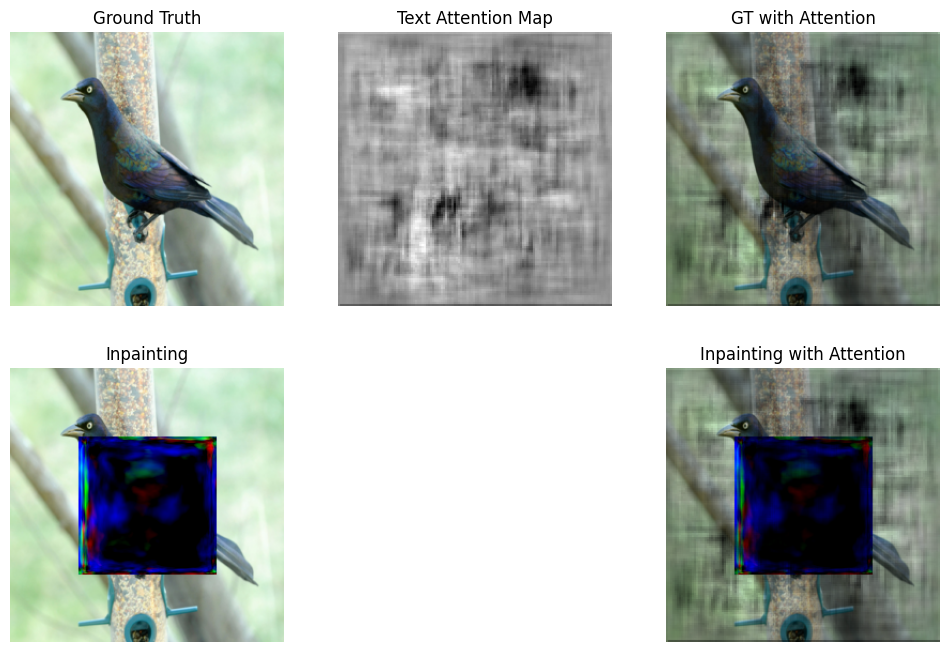

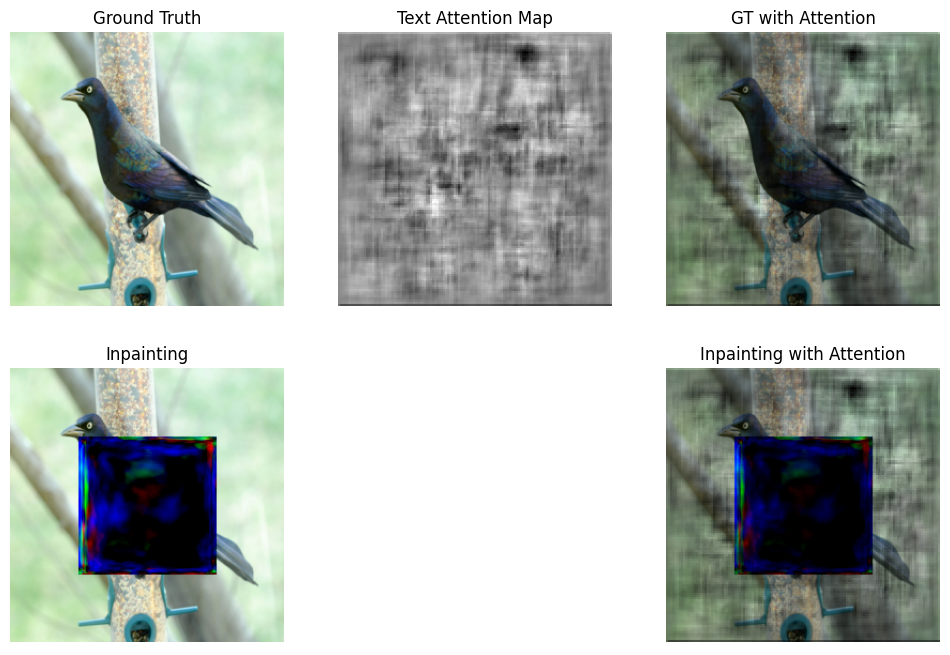

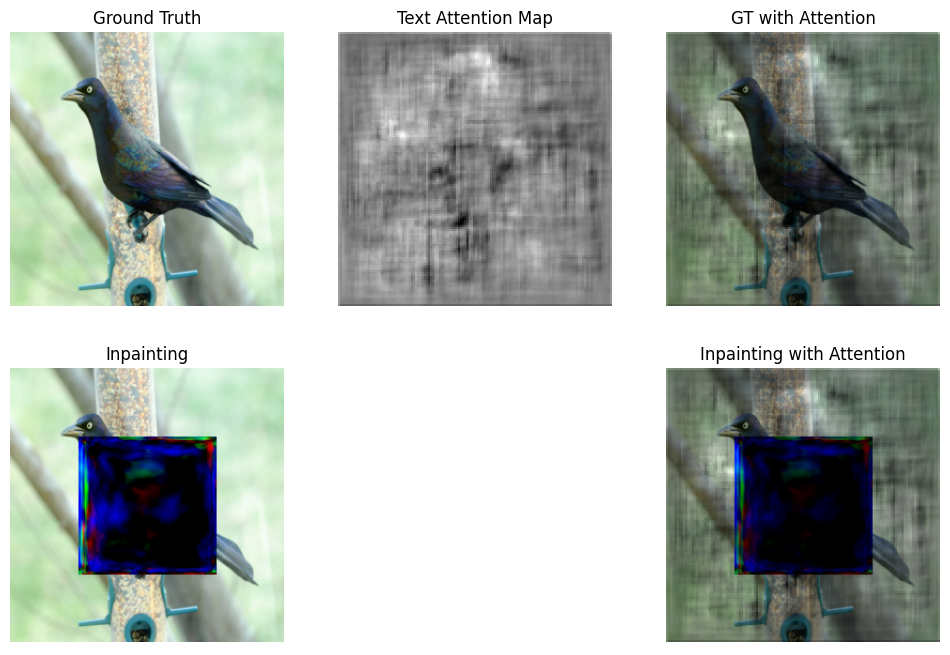

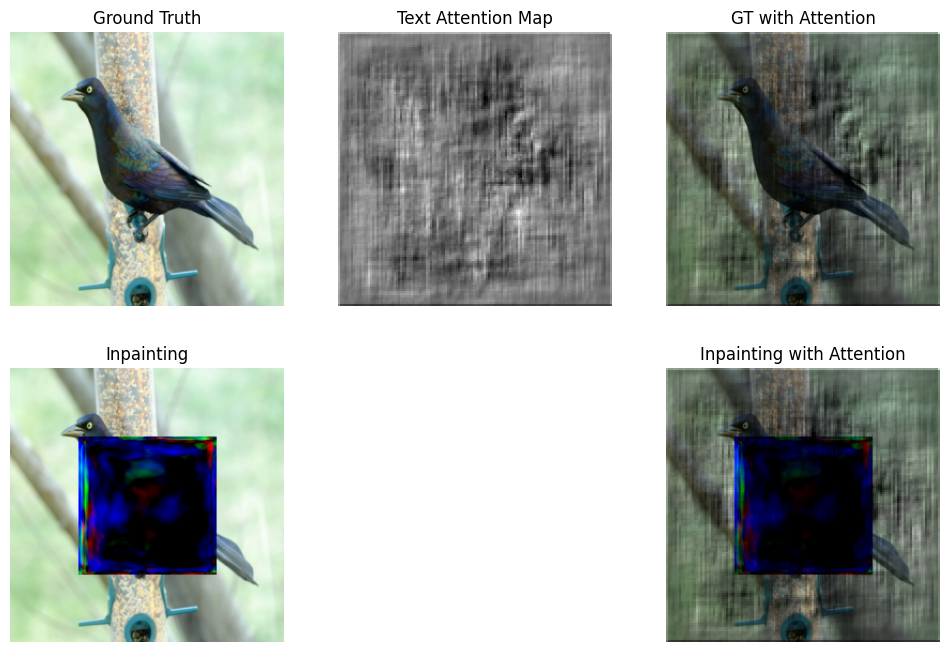

In [ ]:
%%time
for epoch in range(NUM_EPOCHS):
    train_step = 0
    num_steps = len(dataloader)
    while train_step < num_steps:
        imgs, captions, cap_lens, cls_ids, cap_texts = get_data(dataloader)
        hidden = text_encoder.init_hidden(BATCH_SIZE)
        
        words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
        words_embs, sent_emb = words_embs.detach(), sent_emb.detach()
        
        text_mask = (captions == 0)
        num_words = words_embs.size(2)
        if text_mask.size(1) > num_words:
            text_mask = text_mask[:, :num_words]
        text_mask = text_mask.to(device)
        
        mask = get_mask()
        masked = imgs * (1. - mask)
        
        noise = noise.data.normal_(0, 1).to(device)

        # Train Discriminator
        for _ in range(n_critic):
            d_optimizer.zero_grad()
            
            coarse_result_t, refine_result_t, attn_loss = g_model(masked, mask, noise, sent_emb, words_embs, text_mask)
            
            _, d_loss = calc_wgan_loss(d_model, refine_result_t.detach(), imgs)
            gradient_penalty = compute_gradient_penalty(d_model, imgs.data, refine_result_t.data)
            
            lambda_gp = 10  
            d_loss = d_loss + lambda_gp * gradient_penalty
            
            d_loss.backward()
            d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        
        coarse_result_t, refine_result_t, attn_loss = g_model(masked, mask, noise, sent_emb, words_embs, text_mask)
        
        region_features, cnn_code = image_encoder(refine_result_t.clone())
        
        w_loss0, w_loss1, _ = words_loss(region_features, words_embs, match_labels, cap_lens, cls_ids, BATCH_SIZE, torch.cuda.is_available())
        w_loss = (w_loss0 + w_loss1) * 1.0
        
        s_loss0, s_loss1 = sent_loss(cnn_code, sent_emb, match_labels, cls_ids, BATCH_SIZE, torch.cuda.is_available())
        s_loss = (s_loss0 + s_loss1) * 1.0
        
        matching_loss = w_loss + s_loss
        
        g_loss, _ = calc_wgan_loss(d_model, refine_result_t, imgs)
        
        recon_loss_t = get_recon_loss(mask, imgs, coarse_result_t, L1Loss) + \
                      get_recon_loss(mask, imgs, refine_result_t, L1Loss) + \
                      L1Loss(refine_result_t * attn_loss, imgs * attn_loss)
        
        lambda_match = 0.001  
        lambda_recon = 1.0    
        lambda_adv = 0.002    

        total_loss_t = lambda_recon * recon_loss_t + \
                      lambda_match * matching_loss + \
                      lambda_adv * g_loss
        
        total_loss_t.backward()
        g_optimizer.step()
        
        # Visualization at specific intervals
        if train_step % 500 == 0:
            print()
            print(f"Epoch {epoch}/{NUM_EPOCHS}\nBatch {train_step}/{num_steps}")
            print(f"TIM={matching_loss}, RECON={recon_loss_t}, WGAN_LOSS={g_loss}, TOTAL={total_loss_t}")
            
            fin_img = refine_result_t[0].cpu().detach().numpy().transpose(1,2,0)
            gt_img = imgs[0].cpu().detach().numpy().transpose(1,2,0)
            
            visualize_results(gt_img, fin_img, attn_loss)
        
        train_step += 1

In [ ]:
torch.save(g_model.state_dict(), '/kaggle/working/GenWts')
torch.save(d_model.state_dict(),'/kaggle/working/DiscWts' )

In [ ]:
# imgs, captions, cap_lens, cls_ids, cap_texts = get_data(dataloader)

In [ ]:
# hidden = text_encoder.init_hidden(BATCH_SIZE)

# words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
# words_embs, sent_emb = words_embs.detach(), sent_emb.detach()

In [ ]:
# text_mask = (captions == 0)

In [ ]:
# num_words = words_embs.size(2)
# if text_mask.size(1) > num_words:
#     text_mask = text_mask[:, :num_words]

In [ ]:
# img = imgs[-1]
# mask = get_mask()
# masked = img * (1. - mask)
# masked.shape

In [ ]:
# noise = noise.data.normal_(0, 1)

In [ ]:
# g_model = InpaintNet().to(device)

In [ ]:
# d_model = PatchDiscriminator().to(device)

In [ ]:
# coarse_result_t, refine_result_t, attn_loss = g_model(masked.to(device), mask.to(device), noise.to(device), sent_emb.to(device), words_embs.to(device), text_mask.to(device))

In [ ]:
# region_features, cnn_code = image_encoder(refine_result_t)

In [ ]:
# w_loss0, w_loss1, _ = words_loss(region_features, words_embs, match_labels, cap_lens, cls_ids, BATCH_SIZE , torch.cuda.is_available())
# w_loss = (w_loss0 + w_loss1) * 1.0

In [ ]:
# s_loss0, s_loss1 = sent_loss(cnn_code, sent_emb, match_labels, cls_ids, BATCH_SIZE, torch.cuda.is_available())
# s_loss = (s_loss0 + s_loss1) * 1.0

In [ ]:
# matching_loss = w_loss + s_loss

In [ ]:
# pg_loss_t, pd_loss_t = calc_gan_loss(d_model, refine_result_t, imgs)

In [ ]:
# recon_loss_t = L1Loss(coarse_result_t, img) + L1Loss(refine_result_t, img) + L1Loss(refine_result_t * attn_loss, img * attn_loss)  ### RECON LOSS AND TGA HERE
# gan_loss_t = pg_loss_t

# total_loss_t = 1*recon_loss_t + 0.002*gan_loss_t + 0.001*matching_loss